DEBUG
%0 = x                   # EncryptedScalar<int10>        ∈ [-234, 282]
%1 = subgraph(%0)        # EncryptedScalar<uint1>        ∈ [0, 1]
return %1

Subgraphs:

    %1 = subgraph(%0):

         %0 = input                            # EncryptedScalar<int9>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 0.0                              # ClearScalar<float64>
         %5 = add(%3, %4)                      # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(%5, %6)                  # EncryptedScalar<uint1>
         %8 = multiply(%5, %7)                 # EncryptedScalar<float64>
         %9 = 118                              # ClearScalar<uint7>
        %10 = floor_divide(%8, %9)             # EncryptedScalar<float64>
        %11 = rint(%1

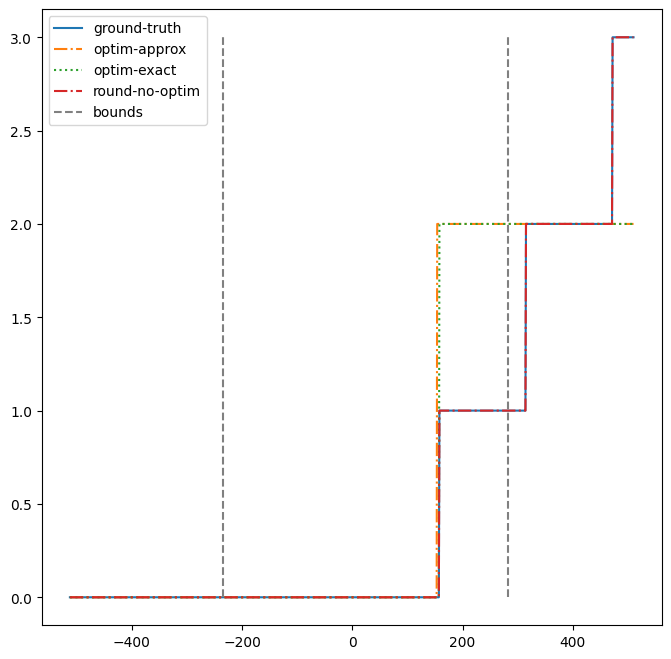

In [1]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
from concrete.fhe import Configuration, Integer, univariate

from concrete import fhe
from concrete.ml.common.preprocessors import InsertRounding, TLUDeltaBasedOptimizer

np.random.seed(42)

input_range = (-234, 283)

inputset = np.arange(input_range[0], input_range[1], dtype=np.int64)
integer = Integer.that_can_represent(inputset)
full_range = np.arange(integer.min(), integer.max(), dtype=np.int64)

# Constant function


def f(x):
    x = x.astype(np.float64)
    x = 0.75 * x - 200
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


# 2 jumps -> like what we have in CIFAR


def f(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 134.0
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


# 1 jump


def f(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 0.0
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


# 5 jumps


def f(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 163.0
    x = x * (x > 0)
    x = x // 69
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


def make_step_function(n_thresholds, delta, x_min, x_max, power_of_two=False):
    """Make a step function using a TLU."""
    thresholds_ = []  # First threshold

    if power_of_two:
        th0 = numpy.random.randint(0, delta)
    else:
        th0 = numpy.random.randint(x_min, x_max)

    for index in range(n_thresholds):
        thresholds_.append(th0 + index * delta)

    thresholds = tuple(thresholds_)

    # Step size function to optimize
    def util(x):
        return sum([numpy.where(x >= float(threshold), 1.0, 0.0) for threshold in thresholds])

    def step_function(x):
        return univariate(util)(x).astype(numpy.int64)

    def f(x):
        return step_function(x.astype(numpy.float64))

    def constant_f(x):
        return univariate(lambda x: th0 * (1.0 - (x.astype(numpy.float64) * 0.0)))(x).astype(
            numpy.int64
        )

    if n_thresholds == 0:
        return constant_f
    return f

execution_number = 4
n_bits_from = execution_number + 2
x_min, x_max = -(2 ** (n_bits_from)), (2 ** (n_bits_from)) - 1
delta = 2 ** (n_bits_from // 2)  # Constant step size assumption
f = make_step_function(execution_number, delta, x_min, x_max, True)


def f(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 0.0
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x
    
input_range = (-234, 283)
inputset = np.arange(input_range[0], input_range[1], dtype=np.int64)
integer = Integer.that_can_represent(inputset)
full_range = np.arange(integer.min(), integer.max(), dtype=np.int64)

def compute(circuit):
    Y = []
    X = []

    for x in full_range:
        y = circuit.simulate(x)
        X.append(x)
        Y.append(y)

    return np.array(Y)


# Naive
f_naive = fhe.compiler({"x": "encrypted"})(f)

circuit_naive = f_naive.compile(inputset)

naive_res = compute(circuit_naive)

# Optim - Approx
exactness = fhe.Exactness.APPROXIMATE
optim = TLUDeltaBasedOptimizer(overflow_protection=True, exactness=exactness, verbose=1)
pre_proc_optim = [optim]
cfg_optim = Configuration(additional_pre_processors=pre_proc_optim)

f_optim = fhe.compiler({"x": "encrypted"})(f)

circuit_optim = f_optim.compile(inputset, configuration=cfg_optim)

optim_res = compute(circuit_optim)

# Optim - Res
exactness = fhe.Exactness.EXACT
optim_exact = TLUDeltaBasedOptimizer(overflow_protection=True, exactness=exactness, verbose=1)
pre_proc_optim_exact = [optim_exact]
cfg_optim_exact = Configuration(additional_pre_processors=pre_proc_optim_exact)

f_optim_exact = fhe.compiler({"x": "encrypted"})(f)

circuit_optim_exact = f_optim_exact.compile(inputset, configuration=cfg_optim_exact)

optim_res_exact = compute(circuit_optim_exact)

# Round (bit-width-from-optim)
n_bits_round = (
    list(optim.statistics.values())[0]["optimized_bit_width"] if optim.statistics else None
)
rounding_from_optim_no_scaling = InsertRounding(n_bits_round, overflow_protection=True)
pre_proc_round_from_optim_no_scaling = [rounding_from_optim_no_scaling]
cfg_round_from_optim_no_scaling = Configuration(
    additional_pre_processors=pre_proc_round_from_optim_no_scaling
)

f_round_from_optim_no_scaling = fhe.compiler({"x": "encrypted"})(f)

circuit_round_from_optim_no_scaling = f_round_from_optim_no_scaling.compile(
    inputset, configuration=cfg_round_from_optim_no_scaling
)

round_res_from_optim_no_scaling = compute(circuit_round_from_optim_no_scaling)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(full_range, naive_res, label="ground-truth", linestyle="-")
ax.plot(full_range, optim_res, label="optim-approx", linestyle="-.")
ax.plot(full_range, optim_res_exact, label="optim-exact", linestyle=":")
ax.plot(full_range, round_res_from_optim_no_scaling, label="round-no-optim", linestyle="-.")
ax.vlines(
    input_range, np.min(naive_res), np.max(naive_res), color="grey", linestyle="--", label="bounds"
)
plt.legend()

# Set the secondary ticks
if False:
    lsbs_to_remove = integer.bit_width - list(optim.statistics.values())[0]["optimized_bit_width"]
    rounded_ticks = full_range[
        np.concatenate(
            [
                np.diff(fhe.round_bit_pattern(full_range, lsbs_to_remove=lsbs_to_remove)).astype(
                    bool
                ),
                np.array(
                    [
                        False,
                    ]
                ),
            ]
        )
    ]

    # Create secondary axes for the top ticks
    ax_top = ax.twiny()
    ax_top.set_xlim(
        ax.get_xlim()
    )  # Make sure the secondary axis has the same limits as the primary axis

    # Set the secondary ticks
    ax_top.set_xticks(rounded_ticks)

    # Customize appearance of secondary ticks
    ax_top.tick_params(which="minor", length=4, color="red")

plt.show()